# Population Demographics, City Immigration and Tempurature Analysis
### Data Engineering Capstone Project

#### Project Summary
This project analysis the US immigration data and its relationhip with the census data along with weather Tempurature and explores the reason most popular cities for immigration, gender distribution of the immigrants, visa-type distribution of the immigrants, average tempurature distribution of various cities.

For the sake of the project we are using the following datasets:

1. I94 immigration dataset of 2016 
2. City temperature data from Kaggle 
3. US city demographic data from OpenSoft. 

PySpark and Pandas are used for Data Extraction, Data Manipulation and Data Exploration. Pyspark was found to be more useful for the import sas type file and large csv files 

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
"""
Importing and installing  all the required libraries
for data importation and data extraction

"""
import pandas as pd
import psycopg2
from pyspark.sql import SparkSession
from pyspark.sql.types import DateType
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import configparser
import os
from pyspark.sql.functions import count, col, udf, year, month, avg, round, dayofweek, weekofyear, isnull


### Step 1: Scope the Project and Gather Data

#### Scope 
The goal of this project is to extract data from the different sources and design a fact and dimension  table for analyzing US immigration data using Tempurature data, US census data and seasonality

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 

##### 1. I94 Immigration Data: US National Tourism and Trade Office and contains statistics on international visitor arrival in USA and comes from the US National Tourism and Trade Office.

##### 2. World Tempurature Data: Derived from Kaggle and contains average weather tempuratures by city.

##### 3. U.S City Demographic Data: derived from OpenSoft and contains imformation about the demographics of all US cities such as average age, male and female population


In [2]:
"""
Building necessary environment for important sas files and
creating pyspark session

"""

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = "/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/lib/jvm/java-8-openjdk-amd64/bin"
os.environ["SPARK_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"
os.environ["HADOOP_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df_spark =spark.read.load('./sas_data')

#### Immigration Data after importing the sas file using PySpark

In [3]:
df_spark.select('cicid','i94yr','i94res','depdate','count','visatype').show(5)

+---------+------+------+-------+-----+--------+
|    cicid| i94yr|i94res|depdate|count|visatype|
+---------+------+------+-------+-----+--------+
|5748517.0|2016.0| 438.0|20582.0|  1.0|      B1|
|5748518.0|2016.0| 438.0|20591.0|  1.0|      B1|
|5748519.0|2016.0| 438.0|20582.0|  1.0|      B1|
|5748520.0|2016.0| 438.0|20588.0|  1.0|      B1|
|5748521.0|2016.0| 438.0|20588.0|  1.0|      B1|
+---------+------+------+-------+-----+--------+
only showing top 5 rows



In [4]:
df_spark.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [5]:
# Read in the data here
airport=pd.read_csv('airport-codes_csv.csv')
immigration=pd.read_csv('immigration_data_sample.csv')


In [6]:
airline=df_spark.groupby("airline").sum("count").withColumnRenamed("sum(count)","Summation").orderBy("Summation",ascending=False)

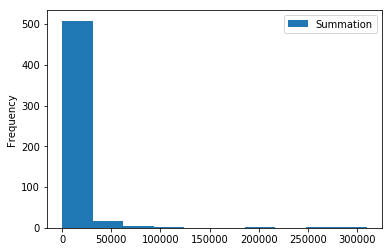

In [7]:
airline.toPandas().plot.hist()

#### Cleaning Immigration dataset

In [8]:
import re
# Create list of valid ports
i94_sas_label_descriptions_fname = "I94_SAS_Labels_Descriptions.SAS"
with open(i94_sas_label_descriptions_fname) as f:
    lines = f.readlines()

re_compiled = re.compile(r"\'(.*)\'.*\'(.*)\'")
valid_ports = {}
for line in lines[302:961]:
    results = re_compiled.search(line)
    valid_ports[results.group(1)] = results.group(2)


### Us Cities descrines the demographics of the different USA Cities like Male population, medain age

In [9]:
file = "us-cities-demographics.csv"
us_cities_spark = spark.read.format("csv").option("delimiter", ";").option("header", "true").load(file)

In [10]:
file = "../../data2/GlobalLandTemperaturesByCity.csv"
df_tempurature = spark.read.format("csv").option("delimiter", ",").option("header", "true").load(file)

In [11]:
df_tempurature.show(4)

+----------+------------------+-----------------------------+-----+-------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01|             6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1743-12-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-01-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-02-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
+----------+------------------+-----------------------------+-----+-------+--------+---------+
only showing top 4 rows



### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.



In [12]:
airport.describe()

,elevation_ft
count,48069.000000
mean,1240.789677
std,1602.363459
min,-1266.000000
25%,205.000000
50%,718.000000
75%,1497.000000
max,22000.000000


#### Cleaning Steps
### Document steps necessary to clean the data

#### Counting missing values from the dataframes

In [13]:
from pyspark.sql.functions import isnan, when, count, col,udf

df_spark_missing=df_spark.select([count(when(isnan(c), c)).alias(c) for c in df_spark.columns])


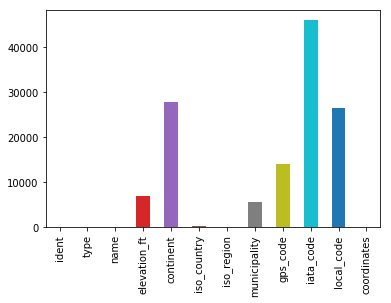

In [14]:
airport.isna().sum().plot.bar()

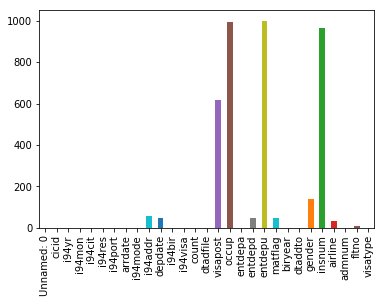

In [15]:
immigration.isna().sum().plot.bar()

In [16]:
# Create list of valid states
valid_states = us_cities_spark.toPandas()["State Code"].unique()
print(len(valid_states))
print(valid_states)

49
['MD' 'MA' 'AL' 'CA' 'NJ' 'IL' 'AZ' 'MO' 'NC' 'PA' 'KS' 'FL' 'TX' 'VA' 'NV'
 'CO' 'MI' 'CT' 'MN' 'UT' 'AR' 'TN' 'OK' 'WA' 'NY' 'GA' 'NE' 'KY' 'SC' 'LA'
 'NM' 'IA' 'RI' 'PR' 'DC' 'WI' 'OR' 'NH' 'ND' 'DE' 'OH' 'ID' 'IN' 'AK' 'MS'
 'HI' 'SD' 'ME' 'MT']


In [17]:
@udf(StringType())
def convert_to_date(x):
    if x:
        return x
    return 'other'

In [18]:
@udf(StringType())
def state_validations(x):
    if x in valid_states:
        return x
    return 'other'

In [19]:
df_spark=df_spark.dropna(how="any",subset=["i94port","i94addr","gender"])
df_spark=df_spark.withColumn("i94addr",state_validations(df_spark.i94addr))
df_spark=df_spark.withColumn("arrdate",convert_to_date(df_spark.arrdate))

In [20]:
df_spark=df_spark.filter(df_spark.i94addr!='other')

In [21]:
df_i94_staging=df_spark.select(col("cicid").alias("id"), 
                                       col("arrdate").alias("date"),
                                       col("i94port").alias("city_code"),
                                       col("i94addr").alias("state_code"),
                                       col("i94bir").alias("age"),
                                       col("gender").alias("gender"),
                                       col("i94visa").alias("visa_type"),
                                       "count").drop_duplicates()

#### Tempurature dataset

In [22]:
df_tempurature.count()

8599212

In [23]:
df_tempurature.limit(3).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.7369999999999999,Århus,Denmark,57.05N,10.33E
1,1743-12-01,None,None,Århus,Denmark,57.05N,10.33E
2,1744-01-01,None,None,Århus,Denmark,57.05N,10.33E


In [24]:
@udf(StringType())
def city_to_port(city):
    for key in valid_ports:
        if city.lower() in valid_ports[key].lower():
            return key

In [25]:
df_tempurature_cleaned=df_tempurature.filter(df_tempurature["Country"] == "United States") \
    .withColumn("year", year(df_tempurature['dt'])) \
    .withColumn("month", month(df_tempurature["dt"])) \
    .withColumn("i94port", city_to_port(df_tempurature["City"])) \
    .withColumn("AverageTemperature", col("AverageTemperature").cast("float")) \
    .dropna(how='any', subset=["i94port"])

In [26]:
df_tempurature_cleaned.show(4)

+----------+------------------+-----------------------------+-----+-------------+--------+---------+----+-----+-------+
|        dt|AverageTemperature|AverageTemperatureUncertainty| City|      Country|Latitude|Longitude|year|month|i94port|
+----------+------------------+-----------------------------+-----+-------------+--------+---------+----+-----+-------+
|1743-11-01|             3.209|           1.9609999999999999|Akron|United States|  40.99N|   80.95W|1743|   11|    AKR|
|1743-12-01|              null|                         null|Akron|United States|  40.99N|   80.95W|1743|   12|    AKR|
|1744-01-01|              null|                         null|Akron|United States|  40.99N|   80.95W|1744|    1|    AKR|
|1744-02-01|              null|                         null|Akron|United States|  40.99N|   80.95W|1744|    2|    AKR|
+----------+------------------+-----------------------------+-----+-------------+--------+---------+----+-----+-------+
only showing top 4 rows



In [27]:
df_tempurature_cleaned = df_tempurature_cleaned.filter(df_tempurature_cleaned["year"] == 2013)


In [28]:
df_tempurature_cleaned.show(3)

+----------+------------------+-----------------------------+-----+-------------+--------+---------+----+-----+-------+
|        dt|AverageTemperature|AverageTemperatureUncertainty| City|      Country|Latitude|Longitude|year|month|i94port|
+----------+------------------+-----------------------------+-----+-------------+--------+---------+----+-----+-------+
|2013-01-01|            -1.086|                         0.22|Akron|United States|  40.99N|   80.95W|2013|    1|    AKR|
|2013-02-01|            -2.213|                        0.226|Akron|United States|  40.99N|   80.95W|2013|    2|    AKR|
|2013-03-01|             1.285|                        0.239|Akron|United States|  40.99N|   80.95W|2013|    3|    AKR|
+----------+------------------+-----------------------------+-----+-------------+--------+---------+----+-----+-------+
only showing top 3 rows



In [29]:
staging_temp_df = df_tempurature_cleaned.select(col("year"), col("month"), col("i94port").alias("city_code"),
                                         round(col("AverageTemperature"), 1).alias("avg_temperature"),
                                         col("Latitude").alias("lat"), col("Longitude").alias("long")).drop_duplicates()

In [30]:
df_tempurature_staging = staging_temp_df.drop_duplicates()
df_tempurature_staging.show(5)

+----+-----+---------+---------------+------+-------+
|year|month|city_code|avg_temperature|   lat|   long|
+----+-----+---------+---------------+------+-------+
|2013|    4|      COL|           16.9|32.95N| 85.21W|
|2013|    1|      DAB|            0.5|39.38N| 83.24W|
|2013|    1|      ONT|            6.8|34.56N|116.76W|
|2013|    2|      POM|            5.8|45.81N|123.46W|
|2013|    5|      PRO|           14.3|42.59N| 72.00W|
+----+-----+---------+---------------+------+-------+
only showing top 5 rows



#### Demographics Data

In [31]:
# Clean demographics data

# Calculate percentages of numeric columns and create new ones
cleaned_us_cities_spark = us_cities_spark.withColumn("median_age", us_cities_spark['Median Age']) \
    .withColumn("pct_male_pop", (us_cities_spark['Male Population'] / us_cities_spark['Total Population']) * 100) \
    .withColumn("pct_female_pop", (us_cities_spark['Female Population'] / us_cities_spark['Total Population']) * 100) \
    .withColumn("pct_veterans", (us_cities_spark['Number of Veterans'] / us_cities_spark['Total Population']) * 100) \
    .withColumn("pct_foreign_born", (us_cities_spark['Foreign-born'] / us_cities_spark['Total Population']) * 100) \
    .withColumn("pct_race", (us_cities_spark['Count'] / us_cities_spark['Total Population']) * 100) \
    .withColumn("city_code", city_to_port(us_cities_spark["City"])) \
    .dropna(how='any', subset=["city_code"])

cleaned_us_cities_spark = cleaned_us_cities_spark.select(col("City").alias("city_name"), col("State Code").alias("state_code"), 
                         "median_age", "pct_male_pop", "pct_female_pop","pct_veterans", 
                         "pct_foreign_born", col("Total Population").alias("total_pop"), 
                         col("Race").alias("race"), "pct_race").drop_duplicates()



In [32]:
cleaned_us_cities_spark.show(3)

+-----------+----------+----------+------------------+------------------+-----------------+------------------+---------+--------------------+------------------+
|  city_name|state_code|median_age|      pct_male_pop|    pct_female_pop|     pct_veterans|  pct_foreign_born|total_pop|                race|          pct_race|
+-----------+----------+----------+------------------+------------------+-----------------+------------------+---------+--------------------+------------------+
|       Reno|        NV|      35.7|50.650464084690796|49.349535915309204|7.077861027240385| 15.35352029257423|   241443|American Indian a...| 1.603691140351967|
|Springfield|        IL|      38.8| 47.22814046465041|  52.7718595353496|6.387457664524781|3.6194178713001555|   117809|  Hispanic or Latino|2.3241008751453625|
|   Columbia|        MD|      37.9| 50.45280137628423| 49.54719862371578|6.307325040834276|22.469966269438565|   103467|               White|56.388027100428154|
+-----------+----------+----------

In [33]:

# Pivot the race column
pivot_demo_df = cleaned_us_cities_spark.groupBy("city_name", "state_code", "median_age", "pct_male_pop",
                                        "pct_female_pop","pct_veterans", "pct_foreign_born", "total_pop").pivot("Race").avg("pct_race")
pivot_demo_df = pivot_demo_df.withColumn("city_code", city_to_port(pivot_demo_df["city_name"])) \
    .dropna(how='any', subset=["city_code"])
staging_demo_df = pivot_demo_df.select("city_code", "state_code", "city_name", "median_age",
                                    round(col("pct_male_pop"), 1).alias("pct_male_pop"),
                                    round(col("pct_female_pop"), 1).alias("pct_female_pop"),
                                    round(col("pct_veterans"), 1).alias("pct_veterans"),
                                    round(col("pct_veterans"), 1).alias("pct_foreign_born"),
                                    round(col("American Indian and Alaska Native"), 1).alias("pct_native_american"),
                                    round(col("Asian"), 1).alias("pct_asian"),
                                    round(col("Black or African-American"), 1).alias("pct_black"),
                                    round(col("Hispanic or Latino"), 1).alias("pct_hispanic_or_latino"),
                                    round(col("White"), 1).alias("pct_white"), "total_pop")


In [34]:
staging_demo_df.show(3)

+---------+----------+--------------+----------+------------+--------------+------------+----------------+-------------------+---------+---------+----------------------+---------+---------+
|city_code|state_code|     city_name|median_age|pct_male_pop|pct_female_pop|pct_veterans|pct_foreign_born|pct_native_american|pct_asian|pct_black|pct_hispanic_or_latino|pct_white|total_pop|
+---------+----------+--------------+----------+------------+--------------+------------+----------------+-------------------+---------+---------+----------------------+---------+---------+
|      TUC|        AZ|        Tucson|      33.6|        49.8|          50.2|         7.2|             7.2|                4.6|      4.6|      6.4|                  43.5|     76.1|   531674|
|      MCA|        TX|         Allen|      37.2|        52.3|          47.7|         3.6|             3.6|                0.2|     16.1|     13.4|                  10.8|     71.2|    98138|
|      CRP|        TX|Corpus Christi|      35.0|  

In [35]:
staging_demo_df.printSchema()

root
 |-- city_code: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- city_name: string (nullable = true)
 |-- median_age: string (nullable = true)
 |-- pct_male_pop: double (nullable = true)
 |-- pct_female_pop: double (nullable = true)
 |-- pct_veterans: double (nullable = true)
 |-- pct_foreign_born: double (nullable = true)
 |-- pct_native_american: double (nullable = true)
 |-- pct_asian: double (nullable = true)
 |-- pct_black: double (nullable = true)
 |-- pct_hispanic_or_latino: double (nullable = true)
 |-- pct_white: double (nullable = true)
 |-- total_pop: string (nullable = true)



### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
The Star schema is chosen as the data model because of its easy of design and effectiveness. Users can write simple to complex queries by joining fact table with the dimension table and perform various OLAP queries

![title](star_schema.png)

### Staging Tables

#### df_staging_i94
    id
    date
    city_code
    state_code
    age
    gender
    visa_type
    count

#### df_tempurature_staging
    year
    month
    city_code
    city_name
    avg_tempurature
    lat
    log


#### staging_demo_df
    city_code
    state_code
    city_name
    median_age
    pct_male_pop
    pct_female_pop
    pct_veterans
    pct_foreign_born
    pct_native_american
    pct_asian
    pct_black
    pct_hispanic_or_latino
    pct_white
    total_pop


### 3.2 Mapping Out Data Pipelines
1. Cleaning the dataset on nulls, datatypes and, duplicates
2. Load the staging tables for the immigrant_df, city_df, monthly_city_temp_df and time_df
3. Create fact table immigration_df with the information on the immigration count, mapping id in immigrant_df, city_code in city_df and monthly_city_temp_df and date in time_df ensuring referential integrity
4. Save processed dimension and fact table in parquet for OLAP queries

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [36]:
# Write code here
df_immigrant = df_i94_staging.select("id", "gender", "age", "visa_type").drop_duplicates()
df_immigrant.limit(5).toPandas()


,id,gender,age,visa_type
0,3473337.0,F,4.0,2.0
1,4891623.0,M,8.0,2.0
2,5897117.0,M,11.0,2.0
3,3133608.0,F,13.0,2.0
4,884031.0,M,15.0,2.0


In [37]:

# Create dimension table for city

city_df = staging_demo_df.join(df_tempurature_staging, "city_code") \
   .select("city_code", "state_code", "city_name", "median_age", "pct_male_pop", "pct_female_pop", "pct_veterans",
           "pct_foreign_born", "pct_native_american", "pct_asian", "pct_black",
           "pct_hispanic_or_latino", "pct_white", "total_pop", "lat", "long").drop_duplicates()

In [38]:
monthly_city_temp_df = df_tempurature_staging.select("city_code", "year", "month", "avg_temperature").drop_duplicates()
monthly_city_temp_df.show(4)

+---------+----+-----+---------------+
|city_code|year|month|avg_temperature|
+---------+----+-----+---------------+
|      SAA|2013|    6|           18.6|
|      PHI|2013|    5|           16.6|
|      BOS|2013|    5|           14.3|
|      BUR|2013|    3|           14.5|
+---------+----+-----+---------------+
only showing top 4 rows



In [39]:
# Create dimension table for time

time_df = df_i94_staging.withColumn("dayofweek", dayofweek("date"))\
                .withColumn("weekofyear", weekofyear("date"))\
                .withColumn("month", month("date"))
                        
time_df = time_df.select("date", "dayofweek", "weekofyear", "month").drop_duplicates()


In [40]:
immigration_df = df_i94_staging.select("id", "state_code", "city_code", "date", "count").drop_duplicates()
immigration_df.show(3)

+---------+----------+---------+-------+-----+
|       id|state_code|city_code|   date|count|
+---------+----------+---------+-------+-----+
|5219472.0|        FL|      NYC|20572.0|  1.0|
|5591722.0|        FL|      MIA|20573.0|  1.0|
| 703662.0|        CA|      LOS|20548.0|  1.0|
+---------+----------+---------+-------+-----+
only showing top 3 rows



In [41]:
# Write dimension tables to parquet
#df_immigrant.write.mode("overwrite").partitionBy("gender", "age").parquet("immigrants")
#city_df.write.mode("overwrite").partitionBy("state_code").parquet("cities")
#monthly_city_temp_df.show(20).write.mode("overwrite").parquet("monthly_city_temperatues")
#time_df.write.mode("overwrite").parquet("time")

# Write fact table to parquet
#immigration_df.write.mode("overwrite").partitionBy("state_code", "city_code").parquet("immigration")

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

# Perform quality checks here

def table_exists(df):
    if df is not None:
        return True
    else:
        return False
        
if table_exists(immigration_df) & table_exists(city_df) & table_exists(monthly_city_temp_df) & table_exists(time_df) & table_exists(immigration_df):
    print("data quality check passed")
    print("dimension tables and fact table exist")
    print()
else:
    print("data quality check failed")
    print("table missing...")

def table_not_empty(df):
    return df.count() != 0 

if table_not_empty(df_immigrant) & table_not_empty(city_df) & table_not_empty(monthly_city_temp_df) & table_not_empty(time_df) & table_not_empty(immigration_df):
    print("data quality check passed!")
    print("dimension tables and fact table contain records")
    print()
else:
    print("data quality check failed!")
    print("null records...")

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Fact Table
    immigration_df
        id: id
        state_code: state code of arrival city
        city_code: city port code of arrival city
        date: date of arrival
        count: count of immigrant's entries into the US
        
#### Dimension Tables

##### immigrant_df
    id: id of immigrant
    gender: gender of immigrant
    age: age of immigrant
    visa_type: immigrant's visa type


##### monthly_city_temp_df
    city_code: city port code
    year: year
    month: month 
    avg_temperature: average temperature in city for given month

##### city_df
    city_code: city port code
    state_code: state code of the city
    city_name: name of the city
    median_age: median age of the city
    pct_male_pop: city's male population in percentage
    pct_female_pop: city's female population in percentage
    pct_veterans: city's veteran population in percentage
    pct_foreign_born: city's foreign born population in percentage
    pct_native_american: city's native american population in percentage
    pct_asian: city's asian population in percentage
    pct_black: city's black population in percentage
    pct_hispanic_or_latino: city's hispanic or latino population in percentage
    pct_white: city's white population in percentage
    total_pop: city's total population
    lat: latitude of the city
    long: longitude of the city

##### time_df
    date: date
    dayofweek: day of the week
    weekofyear: week of year
    month: month



#### Step 5: Complete Project Write Up

Pyspark is an interface for the Apache Spark in Python. It's not only allows you to write spark application using Python API. Pyspark support most of the spark's features such as Spark SQL, Dataframe, Streaming, MLib, and Spark Core. Pypark can read various different data types like csv,sas and parquet. 


The data update cycle is typically chosen on two criteria. One is the reporting cycle, the other is the availabilty of new data to be fed into the system. For example, if new batch of average temperature can be made available at monthly interval, we might settle for monthly data refreshing cycle.

There are also considerations in terms of scaling existing solution.

##### If the data was increased by 100x: We can select high instances of EC2s hosting Spark and/or additional Spark work nodes. With added capacity arising from either vertical scaling or horizontal scaling, we should be able to accelerate processing time.

##### If the data populates a dashboard that must be updated on a daily basis by 7am every day: We can consider using Airflow to schedule and automate the data pipeline jobs. Built-in retry and monitoring mechanism can enable us to meet user requirement.

##### If the database needed to be accessed by 100+ people: We can consider hosting our solution in production scale data warehouse in the cloud, with larger capacity to serve more users, and workload management to ensure equitable usage of resources across users.

In [42]:
time_df.printSchema()

root
 |-- date: string (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- month: integer (nullable = true)



In [43]:
immigration_df.printSchema()

root
 |-- id: double (nullable = true)
 |-- state_code: string (nullable = true)
 |-- city_code: string (nullable = true)
 |-- date: string (nullable = true)
 |-- count: double (nullable = true)



In [44]:
monthly_city_temp_df.printSchema()

root
 |-- city_code: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- avg_temperature: float (nullable = true)



In [45]:
city_df.printSchema()



root
 |-- city_code: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- city_name: string (nullable = true)
 |-- median_age: string (nullable = true)
 |-- pct_male_pop: double (nullable = true)
 |-- pct_female_pop: double (nullable = true)
 |-- pct_veterans: double (nullable = true)
 |-- pct_foreign_born: double (nullable = true)
 |-- pct_native_american: double (nullable = true)
 |-- pct_asian: double (nullable = true)
 |-- pct_black: double (nullable = true)
 |-- pct_hispanic_or_latino: double (nullable = true)
 |-- pct_white: double (nullable = true)
 |-- total_pop: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)



In [46]:
immigration_df.join(city_df, 'city_code', 'inner').select('city_code', 'date','count','city_name','median_age','pct_male_pop').collect()


[Row(city_code='BRO', date='20568.0', count=1.0, city_name='Brownsville', median_age='30.6', pct_male_pop=47.7),
 Row(city_code='BRO', date='20545.0', count=1.0, city_name='Brownsville', median_age='30.6', pct_male_pop=47.7),
 Row(city_code='BRO', date='20567.0', count=1.0, city_name='Brownsville', median_age='30.6', pct_male_pop=47.7),
 Row(city_code='BRO', date='20572.0', count=1.0, city_name='Brownsville', median_age='30.6', pct_male_pop=47.7),
 Row(city_code='BRO', date='20573.0', count=1.0, city_name='Brownsville', median_age='30.6', pct_male_pop=47.7),
 Row(city_code='BRO', date='20565.0', count=1.0, city_name='Brownsville', median_age='30.6', pct_male_pop=47.7),
 Row(city_code='BRO', date='20571.0', count=1.0, city_name='Brownsville', median_age='30.6', pct_male_pop=47.7),
 Row(city_code='BRO', date='20554.0', count=1.0, city_name='Brownsville', median_age='30.6', pct_male_pop=47.7),
 Row(city_code='BRO', date='20551.0', count=1.0, city_name='Brownsville', median_age='30.6', pct